In [1]:
import      numpy               as      np
import      matplotlib.pyplot   as      plt
from        lib_Experimentum    import  *
from        Alessandria         import  *


#path dove stanno i dati del fit
now_path        =   '../BRILLOUIN/TDP43/NO_ARS_12_02/analysis_new_cut_best/'

### recupero info su dimensionalità
spectra_path = '../BRILLOUIN/TDP43/NO_ARS_12_02/'
spectra_filename    =   'NO_ARS_12_02'
n_rows    =   len(Import_from_Matlab(spectra_filename, spectra_path, var_name = 'y3'))
n_cols  =   len(Import_from_Matlab(spectra_filename, spectra_path, var_name = 'y3')[0])
###
matrix, rows, cols = Initialize_Matrix(0,0,n_rows,n_cols)

Ho inizializzato una matrice 101x83, per un totale di 8383 spettri


In [2]:

#1) Recupero info su posizioni + info su chi è bono e chi no e su VIPA (questo solo per matrix[0][0])

with open(now_path+'xy.txt', 'r') as fin:
    lines = fin.readlines()[1:]

excluded = ()

with open(now_path+'markov_fit.txt', 'r') as fin:
    fit     =   eval(fin.read())
_,_,_, boni = Unpack_Fit(fit)

"""
with open(now_path+'xy_VIPA.txt', 'r') as fin:
    VIPAs = fin.readlines()[1:]

x_VIPA = np.array(VIPAs[0][1:-2].split(), dtype=float)
y_VIPA = np.array(VIPAs[1][1:-2].split(), dtype=float)

matrix[0][0].Recover_VIPA(x_VIPA, y_VIPA)
"""
count = 0
for ii in range(len(rows)):
    for jj in range(len(cols)):
        #print(str((ii,jj)))
        matrix[ii][jj].Recover_Spectrum(np.array(lines[count][1:-2].split(), dtype=float), np.array(lines[count+1][1:-2].split(), dtype=float))
        
        if (ii,jj) not in boni:
            excluded = excluded +((ii,jj),)

        count = count + 2

print('Ok ho recuperato le informazioni sulle posizioni')

Ok ho recuperato le informazioni sulle posizioni


In [3]:
#2) Acquisico i dati prodotti dal fit markoviano


##################### MARKOVIANO

with open(now_path+'y_markov_fit.txt', 'r') as fin:
    y_fits = fin.readlines()

with open(now_path+'cost_markov.txt', 'r') as fin:
    costi = fin.readlines()

with open(now_path+'markov_fit_params.txt', 'r') as fin:
    lines   =   fin.readlines()

if (len(boni) != len(lines)):
    raise ValueError("Incompatibilità tra lunghezza file parametri ({}) e informazioni fit ({})".format(len(boni), len(lines)))

for (line, y_fit, cost, (ii,jj)) in zip(lines, y_fits, costi,  boni) :
#for (line, cost, (ii,jj)) in zip(lines, costi,   boni) :
    matrix[ii][jj].Recover_Markov_Fit_Params(line)
    matrix[ii][jj].Recover_y_markov_fit(np.array(y_fit[1:-2].split(), dtype = float))
    matrix[ii][jj].Recover_cost_markov(float(cost))

print('Ok ho recuperato le informazioni del Fit Markoviano')



Ok ho recuperato le informazioni del Fit Markoviano


In [5]:
#Parametri di Interesse per analisi

too_bad = ()
too_good  = ()
omega_too_high =  ()
gamma_too_bad = ()
omega_max = 8.2
gamma_max = 0.35
cost_max = 1000
cost_min = 50

print('Ho trovato per i dati in {} :\n'.format(now_path))


too_bad = Get_Bad_Elements(matrix, boni, cost_max)
too_good = Get_Good_Elements(matrix, boni, cost_min)
omega_too_high = Whose_Param_Too_High('Omega', omega_max, 'markov', matrix, boni)
gamma_too_high = Whose_Param_Too_High('Gamma', gamma_max, 'markov', matrix, boni)

print('{} elementi con Omega > {}\n'.format(len(omega_too_high), omega_max))
print('{} elementi con Gamma > {} \n'.format(len(gamma_too_high), gamma_max))

#aggiunte 
too_bad_gamma = ()
too_offset = ()
percentage_gamma = 15
max_offset = 30
almost_height = ()

for (ii,jj) in boni:
    if matrix[ii][jj].Markov_Fit_Params.T.StdErrs['Gamma'] > (matrix[ii][jj].Markov_Fit_Params.T.Values['Gamma']*(percentage_gamma/100)):
        too_bad_gamma += ((ii,jj),)
    if matrix[ii][jj].Markov_Fit_Params['offset'].values[0] > max_offset:
        too_offset += ((ii,jj),)
    if matrix[ii][jj].y.max() > 15000:
        almost_height += ((ii,jj),)

print('{} elementi con Gamma con errore > {} \n'.format(len(gamma_too_bad), percentage_gamma))
print('{} elementi con offset > {} \n'.format(len(too_offset), max_offset))





Ho trovato per i dati in ../BRILLOUIN/TDP43/NO_ARS_12_02/analysis_new_cut_best/ :

I found 0 bad elements 

I found 6369 good elements 

(68, 24) ha Gamma= 0.39
(70, 45) ha Gamma= 0.38
(71, 24) ha Gamma= 0.39
(78, 26) ha Gamma= 0.40
0 elementi con Omega > 8.2

4 elementi con Gamma > 0.35 

0 elementi con Gamma con errore > 15 

161 elementi con offset > 30 



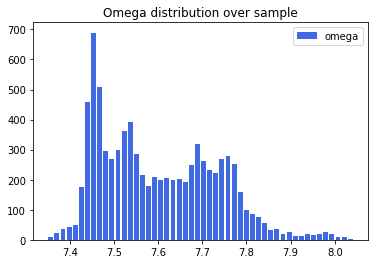

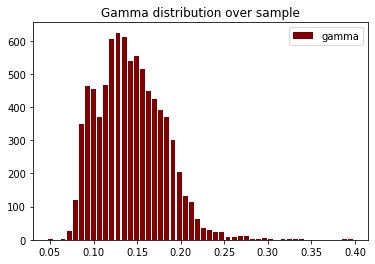

In [23]:
#HISTOGRAMs
plt.figure()
plt.title('Omega distribution over sample')
_ = plt.hist([matrix[ii][jj].Markov_Fit_Params['Omega'].values[0] for (ii,jj) in boni], bins = 50, label = 'omega',histtype = 'bar', stacked = True, rwidth= 0.8,  color = 'royalblue')
plt.legend()
plt.show()
plt.close()
plt.figure()
plt.title('Gamma distribution over sample')
_ = plt.hist([matrix[ii][jj].Markov_Fit_Params['Gamma'].values[0] for (ii,jj) in boni], bins = 50, label = 'gamma', histtype = 'bar', stacked = True, rwidth= 0.8,  color = 'maroon')
plt.legend()
plt.show()
plt.close()

Completata Parameter_Map per Omega
Ho trovato 66 elementi saturati


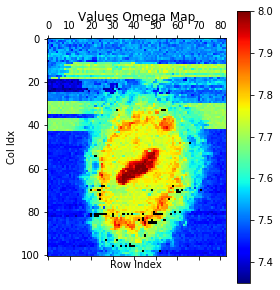

Completata Parameter_Map per Omega
Ho trovato 66 elementi saturati


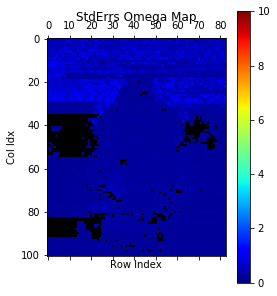

Completata Parameter_Map per Gamma
Ho trovato 66 elementi saturati


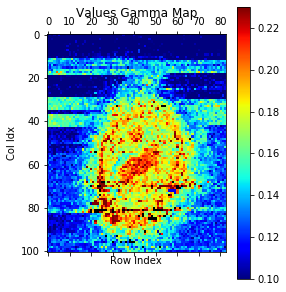

Completata Parameter_Map per Gamma
Ho trovato 66 elementi saturati


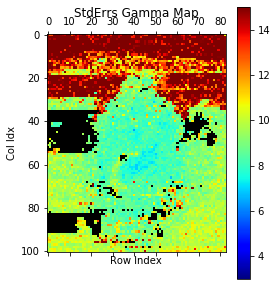

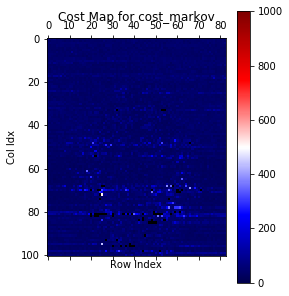

In [27]:
#MAPPE
omega_markov_map, _ = Get_Parameter_Map('markov', 'Omega', matrix, n_rows, n_cols, excluded, 'jet', 7.35, 8., fig = 'omega_markov_map', path=now_path)
Delta_omega_markov_map, _ = Get_Parameter_Map('markov', 'Omega', matrix, n_rows, n_cols, excluded, 'jet', 0,10, fig = 'Delta_omega_markov_map', path=now_path, Deltas = True)
gamma_markov_map, _ = Get_Parameter_Map('markov', 'Gamma', matrix, n_rows, n_cols, excluded, 'jet', 0.1,0.23, fig = 'Gamma_markov_map', path=now_path)
Delta_gamma_markov_map, _ = Get_Parameter_Map('markov', 'Gamma', matrix, n_rows, n_cols, excluded, 'jet', 3, 15, fig = 'Delta_Gamma_markov_map', path=now_path, Deltas = True)
markov_cost_map = Get_cost_map(matrix, 'markov', len(rows), len(cols), 'markov_cost_map', path = now_path)

(0, 0)
                Co     Omega     Gamma  delta_position  delta_width  \
Values    0.099732  7.480746  0.102092        0.420206     0.038661   
StdErrs   0.335642  0.025303  0.012821        0.004207     0.015975   
Initials  0.010000  7.478667  0.100000        0.000000     0.100000   

          delta_amplitude             A         mu      sigma     shift  \
Values           1.263172  5.204003e+03 -10.100700  15.816693  0.127470   
StdErrs          0.910334  8.622860e+09  51.058514  79.134907  0.016792   
Initials         1.000000  5.261980e+03 -10.202727  15.976457  0.000000   

            offset  
Values    3.008833  
StdErrs   2.861444  
Initials  0.000000  


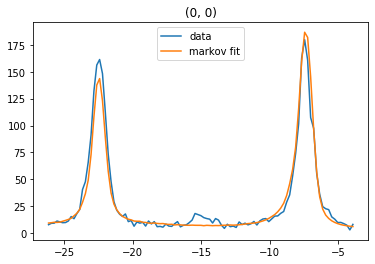

(0, 1)
                Co     Omega     Gamma  delta_position  delta_width  \
Values    0.103893  7.457925  0.111946        0.423575     0.036825   
StdErrs   0.340565  0.021387  0.011769        0.003252     0.012492   
Initials  0.099732  7.480746  0.102092        0.420206     0.038661   

          delta_amplitude             A         mu      sigma     shift  \
Values           1.808923  5.496507e+03  -9.999693  15.658531  0.359663   
StdErrs          1.474158  8.107011e+09  52.078162  74.968542  0.016826   
Initials         1.263172  5.204003e+03 -10.100700  15.816693  0.127470   

            offset  
Values    2.175278  
StdErrs   4.028192  
Initials  3.008833  


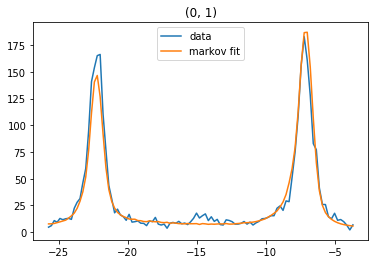

(0, 2)
                Co     Omega     Gamma  delta_position  delta_width  \
Values    0.099607  7.482383  0.102047        0.421985     0.037253   
StdErrs   0.330442  0.024811  0.011981        0.003952     0.011176   
Initials  0.103893  7.457925  0.111946        0.423575     0.036825   

          delta_amplitude             A         mu      sigma     shift  \
Values           1.495038  6.577481e+03  -9.899696  15.501946  0.127806   
StdErrs          0.925795  1.151347e+10  50.248803  73.383166  0.017735   
Initials         1.808923  5.496507e+03  -9.999693  15.658531  0.359663   

            offset  
Values    2.377977  
StdErrs   2.853305  
Initials  2.175278  


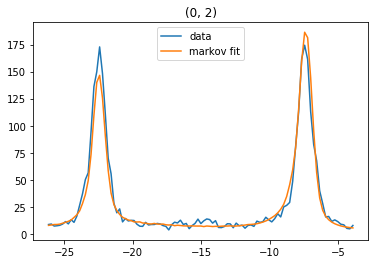

(0, 3)
                Co     Omega     Gamma  delta_position  delta_width  \
Values    0.099585  7.481495  0.109978        0.424405     0.044487   
StdErrs   0.305367  0.022172  0.010875        0.001771     0.002232   
Initials  0.099607  7.482383  0.102047        0.421985     0.037253   

          delta_amplitude             A         mu      sigma     shift  \
Values           3.315419  7.879822e+03  -9.800699  15.346927  0.141482   
StdErrs          1.606940  1.176848e+10  46.430884  65.634227  0.016784   
Initials         1.495038  6.577481e+03  -9.899696  15.501946  0.127806   

            offset  
Values   -0.792679  
StdErrs   3.998782  
Initials  2.377977  


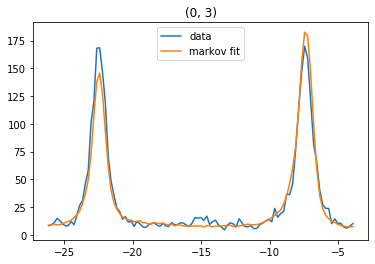

(0, 4)
                Co     Omega     Gamma  delta_position  delta_width  \
Values    0.080520  7.550614  0.074644        0.415921     0.008083   
StdErrs   0.200065  0.054687  0.011660        0.000327     0.001354   
Initials  0.099585  7.481495  0.109978        0.424405     0.044487   

          delta_amplitude             A         mu      sigma     shift  \
Values          18.083407  9.455786e+03  -9.702692  15.193457  0.220976   
StdErrs          7.417008  1.799163e+10  40.758725  49.030364  0.036877   
Initials         3.315419  7.879822e+03  -9.800699  15.346927  0.141482   

            offset  
Values    5.856631  
StdErrs   1.675501  
Initials -0.792679  


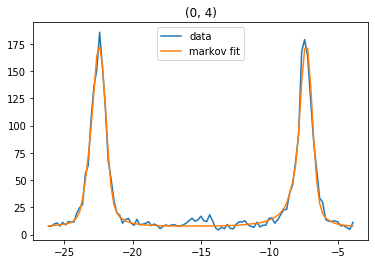

(0, 5)
                Co     Omega     Gamma  delta_position  delta_width  \
Values    0.086782  7.556370  0.110054        0.416044     0.008378   
StdErrs   0.385891  0.051884  0.022434        0.000465     0.001716   
Initials  0.080520  7.550614  0.074644        0.415921     0.008083   

          delta_amplitude             A         mu      sigma     shift  \
Values          17.592413  1.134649e+04  -9.799719  15.345392  0.200654   
StdErrs         10.007233  2.382714e+10  71.428228  90.910695  0.041319   
Initials        18.083407  9.455786e+03  -9.702692  15.193457  0.220976   

            offset  
Values    5.004585  
StdErrs   2.494853  
Initials  5.856631  


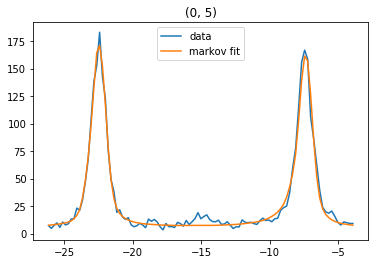

(0, 6)
                Co    Omega     Gamma  delta_position  delta_width  \
Values    0.085189  7.54934  0.080416        0.416164     0.008352   
StdErrs   0.207138  0.05005  0.011862        0.000511     0.002058   
Initials  0.086782  7.55637  0.110054        0.416044     0.008378   

          delta_amplitude             A         mu      sigma     shift  \
Values          13.678387  9.091667e+03  -9.783008  15.191938  0.428889   
StdErrs          7.473282  1.541850e+10  40.510975  48.186008  0.037970   
Initials        17.592413  1.134649e+04  -9.799719  15.345392  0.200654   

            offset  
Values    6.193819  
StdErrs   1.686092  
Initials  5.004585  


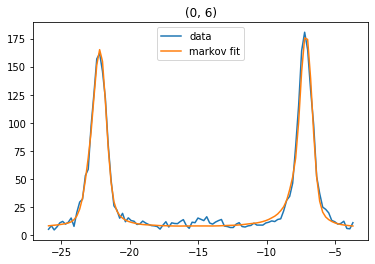

(0, 7)
                Co     Omega     Gamma  delta_position  delta_width  \
Values    0.085492  7.563069  0.077534        0.416170     0.008813   
StdErrs   0.183735  0.040631  0.011604        0.000492     0.001834   
Initials  0.085189  7.549340  0.080416        0.416164     0.008352   

          delta_amplitude             A         mu      sigma     shift  \
Values          14.654798  1.089235e+04  -9.685177  15.179294  0.421231   
StdErrs          6.748423  1.777196e+10  35.982738  42.518662  0.030585   
Initials        13.678387  9.091667e+03  -9.783008  15.191938  0.428889   

            offset  
Values    5.668523  
StdErrs   1.544179  
Initials  6.193819  


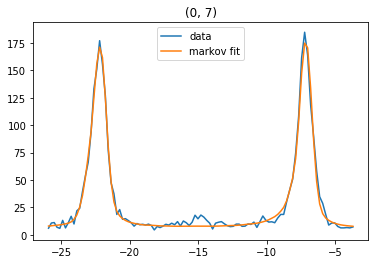

(0, 8)
                Co     Omega     Gamma  delta_position  delta_width  \
Values    0.082636  7.515837  0.090051        0.416063     0.009248   
StdErrs   0.214204  0.039945  0.012663        0.000472     0.001682   
Initials  0.085492  7.563069  0.077534        0.416170     0.008813   

          delta_amplitude             A         mu      sigma     shift  \
Values          14.988747  8.736525e+03  -9.588326  15.027501  0.184455   
StdErrs          7.855434  2.225381e+10  41.342280  49.968021  0.036207   
Initials        14.654798  1.089235e+04  -9.685177  15.179294  0.421231   

            offset  
Values    6.272497  
StdErrs   1.642787  
Initials  5.668523  


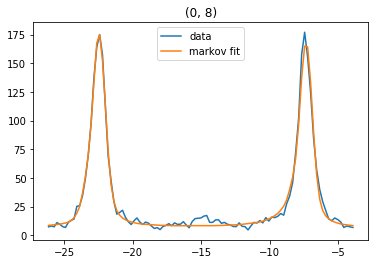

(0, 9)
                Co     Omega     Gamma  delta_position  delta_width  \
Values    0.088264  7.507800  0.085198        0.416168     0.011183   
StdErrs   0.162399  0.029656  0.012904        0.000301     0.001259   
Initials  0.082636  7.515837  0.090051        0.416063     0.009248   

          delta_amplitude             A         mu      sigma     shift  \
Values           9.899120  6.989222e+03  -9.684209  15.177776  0.146087   
StdErrs          5.110963  1.372584e+10  28.497876  37.835186  0.024997   
Initials        14.988747  8.736525e+03  -9.588326  15.027501  0.184455   

            offset  
Values    5.078220  
StdErrs   1.203135  
Initials  6.272497  


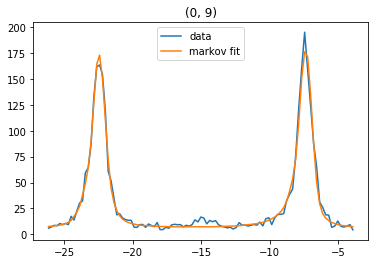

In [55]:
Plot_Elements_Spectrum(matrix, boni[0:10], fit = 'markov')

In [39]:
matrix[17][33].Markov_Fit_Params.values[0]

array([ 1.03018649e-01,  7.65749186e+00,  1.50996976e-01,  1.82541510e+00,
        6.41958371e-01,  1.30711168e+00,  4.24185301e+03, -9.09063000e+00,
        1.42350234e+01,  2.61931780e-01,  8.42524225e+00])

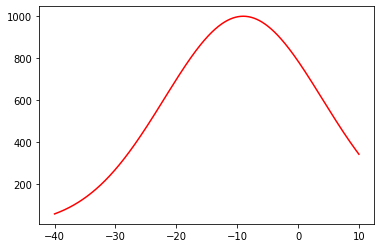

,mu,sigma
Values,-9.002069,12.975015
StdErrs,33.325392,35.394821
Initials,-9.092999,13.106075


In [54]:
plt.figure()
x = np.linspace(-40, 10, 5000)
for (ii,jj) in boni[-1:]:
    plt.plot(x, gaussian(x, 1000, *matrix[ii][jj].Markov_Fit_Params[list(cols_gauss)].values[0][1:]), c = 'r')
    plt.show()
matrix[ii][jj].Markov_Fit_Params[['mu', 'sigma']]


In [11]:
################ TOTALE

with open(now_path+'y_tot_fit.txt', 'r') as fin:
    y_fits = fin.readlines()

with open(now_path+'cost_tot.txt', 'r') as fin:
    costi = fin.readlines()
with open(now_path+'tot_fit_params.txt', 'r') as fin:
    lines   =   fin.readlines()

if (len(boni) != len(lines)):
    raise ValueError("Incompatibilità tra lunghezza file parametri ({}) e informazioni fit ({})".format(len(boni), len(lines)))

for (line, y_fit, cost, (ii,jj)) in zip(lines, y_fits, costi,  boni) :
#for (line, cost, (ii,jj)) in zip(lines, costi,  boni) :
    matrix[ii][jj].Recover_Tot_Fit_Params(line)
    matrix[ii][jj].Recover_y_fit(np.array(y_fit[1:-2].split(), dtype = float))
    matrix[ii][jj].Recover_cost_tot(float(cost))

print('Ok ho recuperato le informazioni del Fit Totale')

Ok ho recuperato le informazioni del Fit Totale


In [16]:
omega_tot_map, _ = Get_Parameter_Map('tot', 'Omega', matrix, n_rows, n_cols, excluded, 'seismic', 7.3, 8.65, fig = 'omega_tot_map', path=now_path)
Delta_omega_tot_map, _ = Get_Parameter_Map('tot', 'Omega', matrix, n_rows, n_cols, excluded, 'seismic', 0,0.7, fig = 'Delta_omega_tot_map', path=now_path, Deltas = True)
gamma_tot_map, _ = Get_Parameter_Map('tot', 'Gamma', matrix, n_rows, n_cols, excluded, 'seismic', 0.1,0.25, fig = 'Gamma_tot_map', path=now_path)
Delta_gamma_tot_map, _ = Get_Parameter_Map('tot', 'Gamma', matrix, n_rows, n_cols, excluded, 'seismic', 0,0.05, fig = 'Delta_gamma_tot_map', path=now_path, Deltas = True)
tau_map, _ = Get_Parameter_Map('tot', 'tau', matrix, n_rows, n_cols, excluded, 'seismic', 0., 1., fig = 'tau_map', path=now_path)
Delta_tau_map, _ = Get_Parameter_Map('tot', 'tau', matrix, n_rows, n_cols, excluded, 'seismic', 0,0.7, fig = 'Delta_tau_map', path=now_path, Deltas = True)

AttributeError: 'Spectrum' object has no attribute 'Tot_Fit_Params'

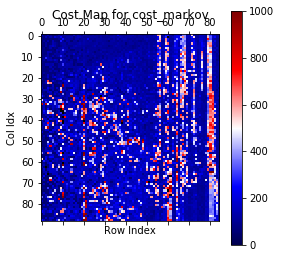

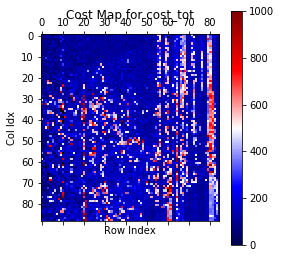

In [30]:
markov_cost_map = Get_cost_map(matrix, 'markov', len(rows), len(cols), 'markov_cost_map', path = now_path)
tot_cost_map = Get_cost_map(matrix, 'tot', len(rows), len(cols), 'tot_cost_map', path = now_path)


(0, 0)


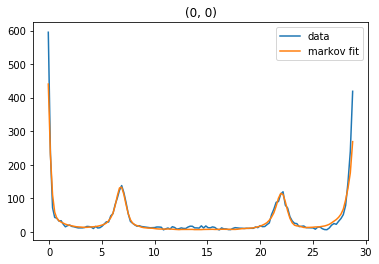

(0, 1)


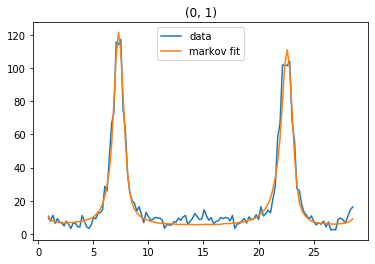

(0, 2)


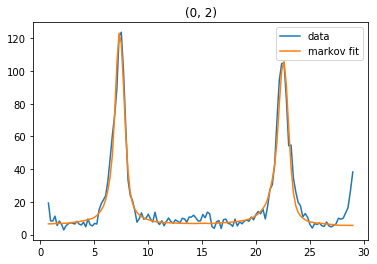

(0, 3)


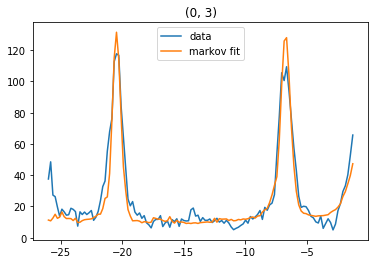

(0, 4)


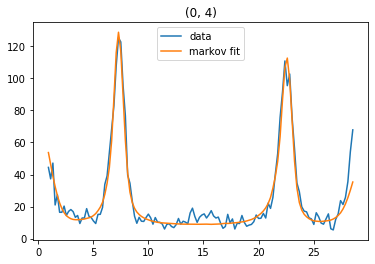

(0, 5)


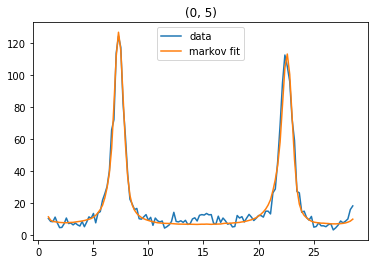

(0, 6)


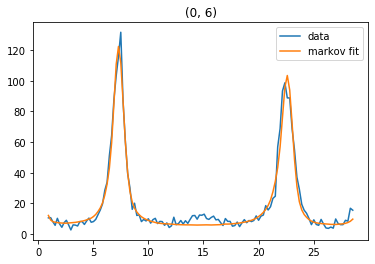

(0, 7)


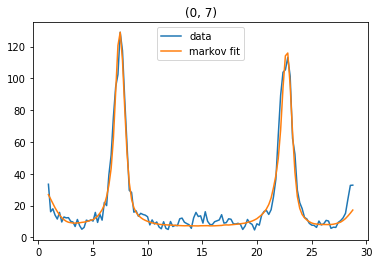

(0, 8)


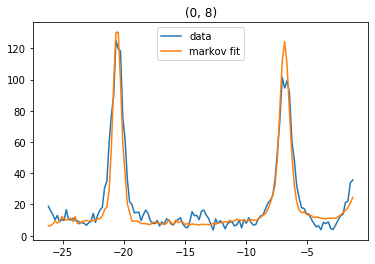

(0, 9)


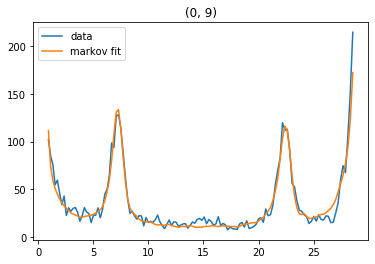

(0, 10)


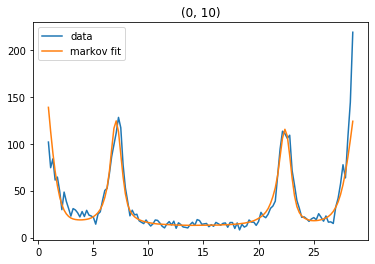

(0, 11)


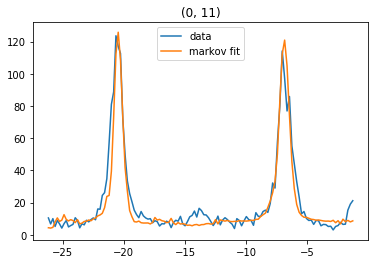

(0, 12)


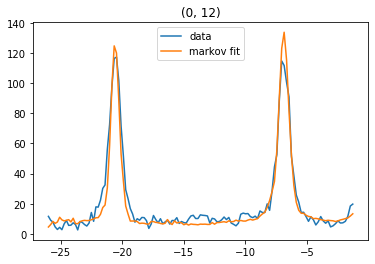

(0, 13)


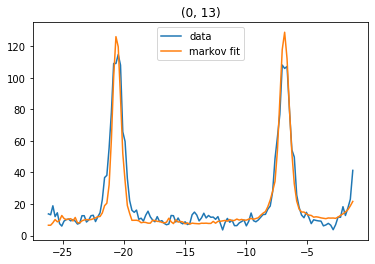

(0, 14)


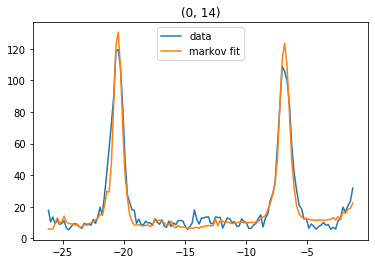

(0, 15)


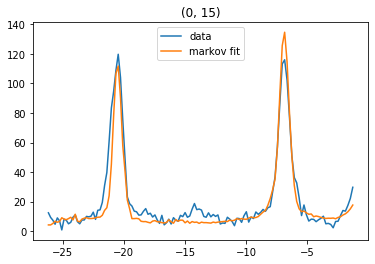

(0, 16)


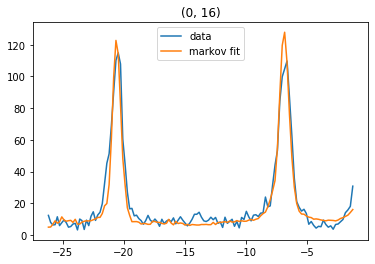

(0, 17)


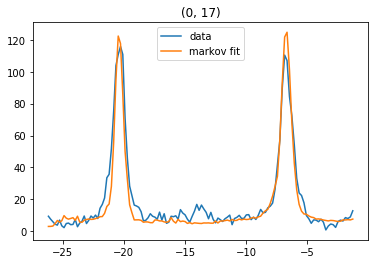

(0, 18)


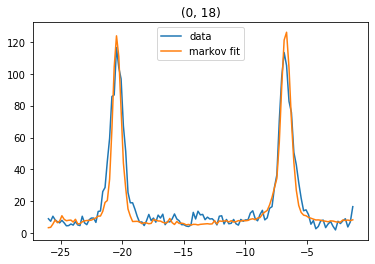

(0, 19)


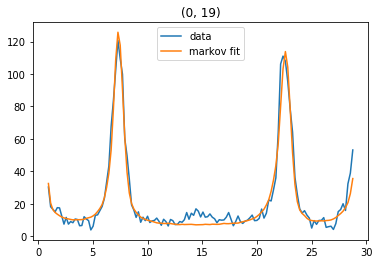

In [33]:
Plot_Elements_Spectrum(matrix, boni[0:20], fit = 'markov')

In [34]:
for (ii,jj) in boni[0:20]:
    print(matrix[ii][jj].Markov_Fit_Params)


Co     Omega     Gamma  delta_width  delta_amplitude  \
Values    0.690403  7.380093  0.119961     0.346559         4.526239   
StdErrs   0.242094  0.019344  0.013036     0.036666         0.880408   
Initials  1.000000  7.653411  0.613204     0.500000         0.100000   

                     A         mu      sigma     shift     offset  
Values    6.848283e+02  10.409714  18.377639 -0.590578   0.756907  
StdErrs   7.409484e+08   7.496846  13.116684  0.015237   0.704313  
Initials  6.226355e+02  10.851784  16.706945  0.000000  22.742063  
                Co     Omega     Gamma  delta_width  delta_amplitude  \
Values    0.576202  7.352200  0.103899     0.331096         0.327227   
StdErrs   0.931994  0.021399  0.013048     0.302070         0.579251   
Initials  1.000000  7.653411  0.613204     0.500000         0.100000   

                     A         mu      sigma     shift     offset  
Values    6.574410e+02   9.766605  15.731842 -0.046762   3.331091  
StdErrs   1.392425e+09  24.854